In [1]:
import sys, os
sys.path.append(os.getcwd())  # so we can import src/* and config/*


In [2]:
from config import settings
from src.pipeline import run_download, run_process, run_build_splits, run_materialize_folds, run_baseline
from src.viz.plots import (
    collect_metrics, plot_metric_bars, plot_cum_pnl,
    plot_pred_vs_true, plot_residual_hist, plot_lastN_ts,
    results_to_df
)

In [3]:
res = run_download()
print("Downloaded datasets:")
for r in res:
    print(f" - {r['symbol']:>8} | {r['rows']:>5} rows | {r['start']} → {r['end']} | {r['path']}")

Downloaded datasets:
 -    ^GSPC |  5049 rows | 2005-10-13 → 2025-11-06 | data/raw/GSPC_2005-10-13_to_2025-11-07_1d.csv
 -      SPY |  5049 rows | 2005-10-13 → 2025-11-06 | data/raw/SPY_2005-10-13_to_2025-11-07_1d.csv
 -  BTC-USD |  4069 rows | 2014-09-17 → 2025-11-06 | data/raw/BTC-USD_2005-10-13_to_2025-11-07_1d.csv
 -  ETH-USD |  2920 rows | 2017-11-09 → 2025-11-06 | data/raw/ETH-USD_2005-10-13_to_2025-11-07_1d.csv
 -    ^NSEI |  4449 rows | 2007-09-17 → 2025-11-06 | data/raw/NSEI_2005-10-13_to_2025-11-07_1d.csv
 - ^NSEBANK |  4174 rows | 2007-09-17 → 2025-11-06 | data/raw/NSEBANK_2005-10-13_to_2025-11-07_1d.csv
 - RELIANCE.NS |  4950 rows | 2005-10-13 → 2025-11-06 | data/raw/RELIANCE.NS_2005-10-13_to_2025-11-07_1d.csv
 -   TCS.NS |  4950 rows | 2005-10-13 → 2025-11-06 | data/raw/TCS.NS_2005-10-13_to_2025-11-07_1d.csv
 - EURUSD=X |  5206 rows | 2005-10-13 → 2025-11-06 | data/raw/EURUSD=X_2005-10-13_to_2025-11-07_1d.csv
 - USDINR=X |  5204 rows | 2005-10-13 → 2025-11-06 | data/raw/US

In [4]:
proc_paths = run_process()
proc_paths

/Users/pep/Projects/setup/DSAI-PROJECT-GROUP-3/src/data/loader.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")
/Users/pep/Projects/setup/DSAI-PROJECT-GROUP-3/src/data/loader.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")


{'GSPC': 'data/processed/GSPC_features.csv',
 'SPY': 'data/processed/SPY_features.csv'}

In [5]:
folds = run_build_splits(proc_paths)
print(f"Built {len(folds)} folds. Example fold[0]: {folds[0] if folds else '—'}")

Built 9 folds. Example fold[0]: {'train': {'start': '2006-01-09', 'end': '2016-01-13'}, 'test': {'start': '2016-01-14', 'end': '2017-01-12'}, 'details': {'train_days': 2520, 'test_days': 252}}


In [6]:
run_materialize_folds(proc_paths, folds)
print("Materialized folds in:", settings.SPLIT_DIR)

Materialized folds in: data/splits


### Main model

In [7]:
result_esn = run_baseline(model_name="esn", fold_id=0, horizon="target_h1")

### Baselines

In [8]:
# Simple linear projection head
result_linear_projection = run_baseline(model_name="ridge", fold_id=0, horizon="target_h1")

# LSTM (32-step window)
result_lstm = run_baseline(model_name="lstm", fold_id=0, horizon="target_h1")

# Transformer (causal)
result_tf = run_baseline(model_name="transformer", fold_id=0, horizon="target_h1")

# Temporal ConvNet
result_tcn = run_baseline(model_name="tcn", fold_id=0, horizon="target_h1")

/Users/pep/Projects/setup/DSAI-PROJECT-GROUP-3/src/models/lstm.py:99: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  ds = TensorDataset(torch.from_numpy(Xa), torch.from_numpy(Ya))


In [9]:
print(result_esn)
print(result_linear_projection)
print(result_lstm) 
print(result_tf)
print(result_tcn)

{'model': 'esn', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.0095516837208836, 'mae': 0.007489353541377207, 'r2': -0.528743562551522, 'dir_acc': 0.5198412698412699, 'backtest': {'avg_daily_pnl': 0.0006922844844429399, 'vol': 0.007720376851819539, 'sharpe': 1.423, 'hit_ratio': 0.52, 'turnover': 0.813}}
{'model': 'ridge', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.007779083020275703, 'mae': 0.005561872626633767, 'r2': -0.013985132194046068, 'dir_acc': 0.4880952380952381, 'backtest': {'avg_daily_pnl': 8.834272064072921e-05, 'vol': 0.007759002756886284, 'sharpe': 0.181, 'hit_ratio': 0.488, 'turnover': 0.726}}
{'model': 'lstm', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.007999830192500857, 'mae': 0.005852988712127457, 'r2': -0.07234939585359368, 'dir_acc': 0.5357142857142857, 'backtest': {'avg_daily_pnl': 0.0005139682834750558, 'vol': 0.007740809772093619, 'sharpe': 1.054, 'hit_ratio': 0.536, 'turnover': 0.71}}
{'model': 'transformer', 'fold': 0, 'horizon': 'target_h1', 'rmse': 0.01686

,model,fold,horizon,rmse,mae,r2,dir_acc,avg_daily_pnl,vol,sharpe,hit_ratio,turnover
0,ridge,0,target_h1,0.007779,0.005562,-0.013985,0.488095,0.000088,0.007759,0.181,0.488,0.726
1,lstm,0,target_h1,0.008000,0.005853,-0.072349,0.535714,0.000514,0.007741,1.054,0.536,0.710
2,esn,0,target_h1,0.009552,0.007489,-0.528744,0.519841,0.000692,0.007720,1.423,0.520,0.813
3,transformer,0,target_h1,0.016867,0.011390,-3.766779,0.511905,0.000179,0.007762,0.366,0.512,0.448
4,tcn,0,target_h1,0.021539,0.016868,-6.773875,0.547619,0.000858,0.007705,1.768,0.548,0.694


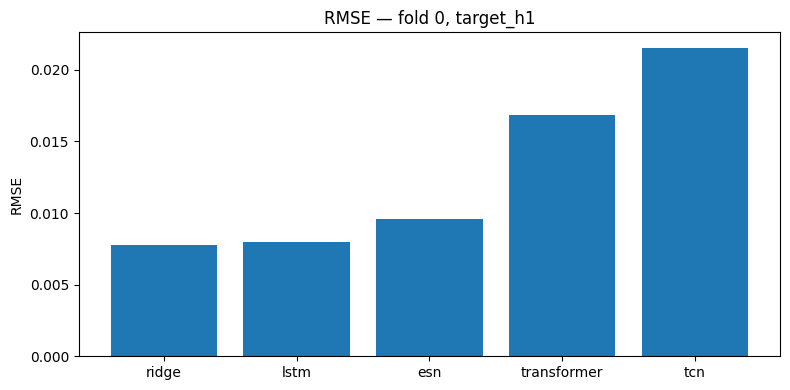

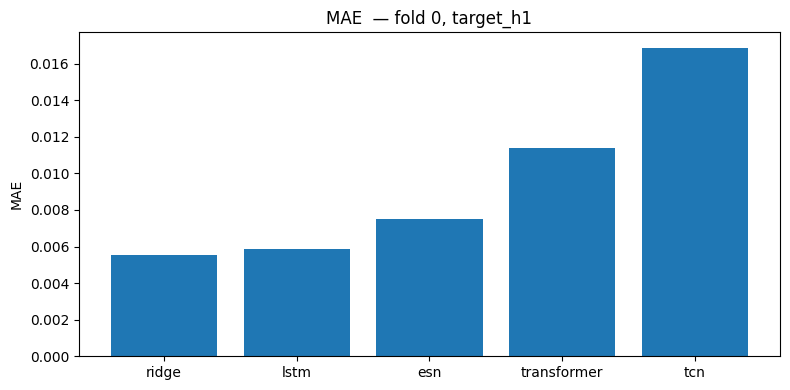

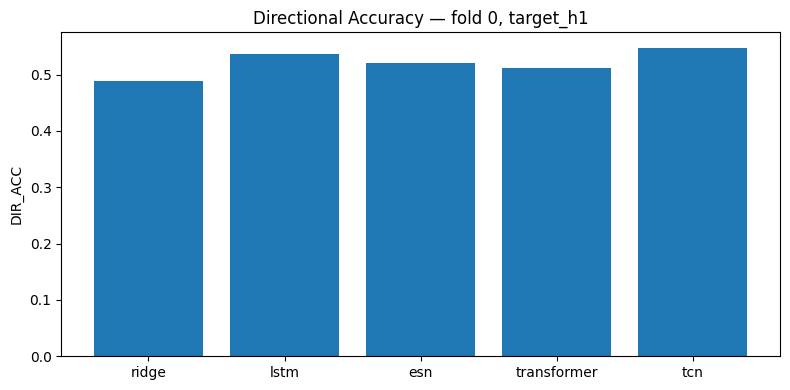

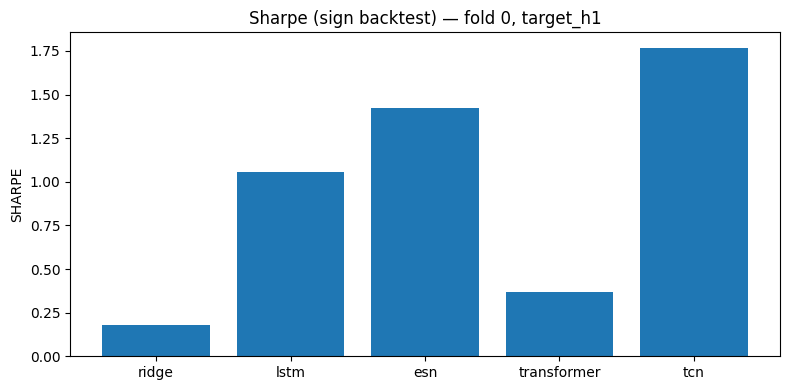

In [10]:
models = ["ridge", "esn", "lstm", "transformer", "tcn"]  # must match registry keys
fold_id = 0
horizon = "target_h1"

dfm = collect_metrics(models, fold_id, horizon)
display(dfm)  # table

# Bar charts
plot_metric_bars(dfm, metric="rmse", title=f"RMSE — fold {fold_id}, {horizon}")
plot_metric_bars(dfm, metric="mae",  title=f"MAE  — fold {fold_id}, {horizon}")
plot_metric_bars(dfm, metric="dir_acc", title=f"Directional Accuracy — fold {fold_id}, {horizon}")
plot_metric_bars(dfm, metric="sharpe", title=f"Sharpe (sign backtest) — fold {fold_id}, {horizon}")

# Tests on longer horizons

In [11]:
result_h5 = run_baseline(model_name="ridge", fold_id=0, horizon="target_h5")
result_h5

{'model': 'ridge',
 'fold': 0,
 'horizon': 'target_h5',
 'rmse': 0.015865607347684548,
 'mae': 0.012164269777884254,
 'r2': -0.1388907904137875,
 'dir_acc': 0.44047619047619047,
 'backtest': {'avg_daily_pnl': -0.0011816581303877459,
  'vol': 0.015383213626917448,
  'sharpe': -1.219,
  'hit_ratio': 0.44,
  'turnover': 0.456}}

In [12]:
result_h20 = run_baseline(model_name="ridge", fold_id=0, horizon="target_h20")
result_h20

{'model': 'ridge',
 'fold': 0,
 'horizon': 'target_h20',
 'rmse': 0.03144108567588757,
 'mae': 0.025035357263321074,
 'r2': -0.7344846762603339,
 'dir_acc': 0.38492063492063494,
 'backtest': {'avg_daily_pnl': -0.00862883086605869,
  'vol': 0.02787749112366821,
  'sharpe': -4.914,
  'hit_ratio': 0.385,
  'turnover': 0.353}}

# Ablations for Milestone 4

In [13]:
from config import settings
from config.experiments import (
    ESN_GRID, LSTM_GRID, TRANSFORMER_GRID, TCN_GRID,
    FOLDS, HORIZONS
)

from src.pipeline import (
    run_download, run_process, run_build_splits, run_materialize_folds
)

from src.train.runner import run_sweep, run_experiment
from src.eval.aggregate import collect_all_metrics, summarize_over_folds

from src.viz.plots import (
    collect_metrics, plot_metric_bars, plot_cum_pnl,
    plot_pred_vs_true, plot_residual_hist, plot_lastN_ts
)

import os, json, pandas as pd, numpy as np

In [14]:
# Which models to sweep
MODELS_TO_RUN = ["esn", "lstm", "transformer", "tcn"]  

# class-defined grids from config/experiments.py
GRIDS = {
    "esn": ESN_GRID,
    "lstm": LSTM_GRID,
    "transformer": TRANSFORMER_GRID,
    "tcn": TCN_GRID,
}

print("Folds:", FOLDS)
print("Horizons:", HORIZONS)
for m in MODELS_TO_RUN:
    print(f"{m} grid size =", np.prod([len(v) for v in GRIDS[m].values()]))


Folds: [0]
Horizons: ['target_h1']
esn grid size = 16
lstm grid size = 16
transformer grid size = 2
tcn grid size = 8


In [15]:
sweep_results = {}
for m in MODELS_TO_RUN:
    print(f"\n=== Running sweep: {m} ===")
    df = run_sweep(model_name=m,
                   param_grid=GRIDS[m],
                   folds=FOLDS,
                   horizons=HORIZONS,
                   exp_prefix="m4")
    sweep_results[m] = df
    display(df.head(3))



=== Running sweep: esn ===


sweep:esn: 100%|████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.18it/s]


,model,exp_id,fold,horizon,rmse,mae,r2,dir_acc,avg_daily_pnl,vol,sharpe,hit_ratio,turnover
0,esn,m4_hidden_size400_spectral_radius0.85_leak_rat...,0,target_h1,0.011508,0.009019,-1.218900,0.507937,0.000118,0.007762,0.242,0.508,0.361
1,esn,m4_hidden_size400_spectral_radius0.85_leak_rat...,0,target_h1,0.009101,0.007012,-0.387737,0.500000,0.000248,0.007757,0.507,0.500,0.313
2,esn,m4_hidden_size400_spectral_radius0.85_leak_rat...,0,target_h1,0.009417,0.007296,-0.485833,0.547619,0.000627,0.007736,1.286,0.548,0.909



=== Running sweep: lstm ===


sweep:lstm: 100%|███████████████████████████████████████████████████| 16/16 [03:34<00:00, 13.42s/it]


,model,exp_id,fold,horizon,rmse,mae,r2,dir_acc,avg_daily_pnl,vol,sharpe,hit_ratio,turnover
0,lstm,m4_seq_len32_hidden128_epochs15_24265f0e,0,target_h1,0.008000,0.005853,-0.072349,0.535714,0.000514,0.007741,1.054,0.536,0.710
1,lstm,m4_seq_len32_hidden128_epochs15_869fec03,0,target_h1,0.008000,0.005853,-0.072349,0.535714,0.000514,0.007741,1.054,0.536,0.710
2,lstm,m4_seq_len32_hidden128_epochs15_73029574,0,target_h1,0.007795,0.005612,-0.018151,0.515873,0.000497,0.007745,1.019,0.516,0.187



=== Running sweep: transformer ===


sweep:transformer: 100%|██████████████████████████████████████████████| 2/2 [00:40<00:00, 20.31s/it]


,model,exp_id,fold,horizon,rmse,mae,r2,dir_acc,avg_daily_pnl,vol,sharpe,hit_ratio,turnover
0,transformer,m4_seq_len32_d_model128_epochs15_341648fd,0,target_h1,0.015017,0.010297,-2.778862,0.488095,0.000187,0.007765,0.381,0.488,0.520
1,transformer,m4_seq_len64_d_model128_epochs15_09dfabeb,0,target_h1,0.018937,0.013021,-5.008650,0.484127,0.000038,0.007762,0.078,0.484,0.282



=== Running sweep: tcn ===


sweep:tcn: 100%|█████████████████████████████████████████████████████| 8/8 [18:58<00:00, 142.31s/it]


,model,exp_id,fold,horizon,rmse,mae,r2,dir_acc,avg_daily_pnl,vol,sharpe,hit_ratio,turnover
0,tcn,m4_seq_len32_channels64_64_epochs15_7378a409,0,target_h1,0.019704,0.014992,-5.505334,0.567460,0.000944,0.007690,1.949,0.567,0.790
1,tcn,m4_seq_len32_channels64_64_epochs15_ec981f35,0,target_h1,0.011896,0.008824,-1.371283,0.559524,0.000639,0.007739,1.311,0.560,0.948
2,tcn,m4_seq_len32_channels64_128_epochs15_45a48935,0,target_h1,0.012446,0.009426,-1.595504,0.547619,0.000865,0.007699,1.783,0.548,0.821


In [16]:
def list_exp_ids(model: str):
    base = os.path.join(settings.EXP_DIR, model)
    return sorted([d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]) if os.path.exists(base) else []

def rank_experiments(model: str, horizon: str, key: str = "sharpe", ascending: bool = False, top_k: int = 3):
    """
    Load all exp_ids for `model`, aggregate over folds for `horizon`,
    and rank by `key` (e.g., 'rmse' asc or 'sharpe' desc).
    """
    rows = []
    for exp_id in list_exp_ids(model):
        df = collect_all_metrics(model, exp_id)
        if df.empty or horizon not in df["horizon"].unique():
            continue
        sub = df[df["horizon"] == horizon].copy()
        agg = sub.mean(numeric_only=True).to_dict()
        agg["model"] = model
        agg["exp_id"] = exp_id
        rows.append(agg)
    if not rows:
        return pd.DataFrame()
    tab = pd.DataFrame(rows)
    tab = tab.sort_values(key, ascending=ascending).reset_index(drop=True)
    return tab.head(top_k)

H = HORIZONS[0]  # choose one for the table

leader_rmse = []
leader_sharpe = []
for m in MODELS_TO_RUN:
    r1 = rank_experiments(m, H, key="rmse", ascending=True, top_k=1)
    r2 = rank_experiments(m, H, key="sharpe", ascending=False, top_k=1)
    if not r1.empty: leader_rmse.append(r1.iloc[0])
    if not r2.empty: leader_sharpe.append(r2.iloc[0])

leader_rmse = pd.DataFrame(leader_rmse)
leader_sharpe = pd.DataFrame(leader_sharpe)

print("== Best by RMSE (per model) ==")
display(leader_rmse[["model","exp_id","rmse","mae","r2","dir_acc","sharpe"]])

print("== Best by Sharpe (per model) ==")
display(leader_sharpe[["model","exp_id","rmse","mae","r2","dir_acc","sharpe"]])


== Best by RMSE (per model) ==


,model,exp_id,rmse,mae,r2,dir_acc,sharpe
0,esn,m4_hidden_size400_spectral_radius0.85_leak_rat...,0.009101,0.007012,-0.387737,0.500000,0.507
0,lstm,m4_seq_len64_hidden256_epochs15_82a1764c,0.007665,0.005484,0.015496,0.535714,1.342
0,transformer,m4_seq_len32_d_model128_epochs15_341648fd,0.015017,0.010297,-2.778862,0.488095,0.381
0,tcn,m4_seq_len32_channels64_128_epochs15_3889c8ee,0.009190,0.006858,-0.415087,0.527778,1.198


== Best by Sharpe (per model) ==


,model,exp_id,rmse,mae,r2,dir_acc,sharpe
0,esn,m4_hidden_size800_spectral_radius0.85_leak_rat...,0.021002,0.017748,-6.390700,0.507937,1.330
0,lstm,m4_seq_len32_hidden256_epochs15_00960fb7,0.007742,0.005599,-0.004456,0.519841,1.415
0,transformer,m4_seq_len32_d_model128_epochs15_341648fd,0.015017,0.010297,-2.778862,0.488095,0.381
0,tcn,m4_seq_len32_channels64_64_epochs15_7378a409,0.019704,0.014992,-5.505334,0.567460,1.949


Winners (Sharpe):


,model,exp_id
0,esn,m4_hidden_size800_spectral_radius0.85_leak_rat...
0,lstm,m4_seq_len32_hidden256_epochs15_00960fb7
0,transformer,m4_seq_len32_d_model128_epochs15_341648fd
0,tcn,m4_seq_len32_channels64_64_epochs15_7378a409


,model,rmse,mae,r2,dir_acc,sharpe,avg_daily_pnl,turnover
0,esn,0.021002,0.017748,-6.390700,0.507937,1.330,0.000648,0.210
1,lstm,0.007742,0.005599,-0.004456,0.519841,1.415,0.000689,0.345
2,transformer,0.015017,0.010297,-2.778862,0.488095,0.381,0.000187,0.520
3,tcn,0.019704,0.014992,-5.505334,0.567460,1.949,0.000944,0.790


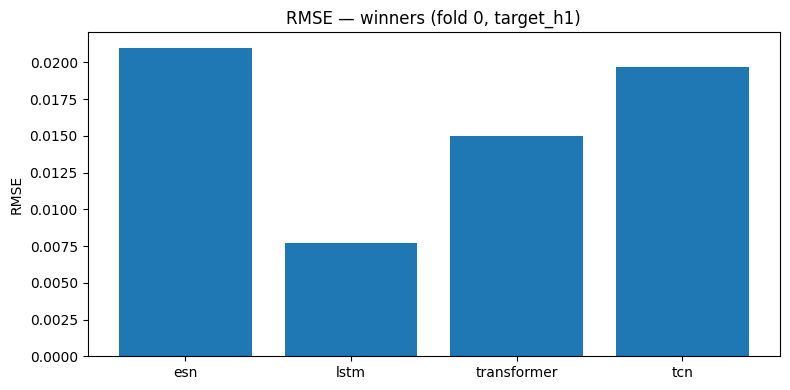

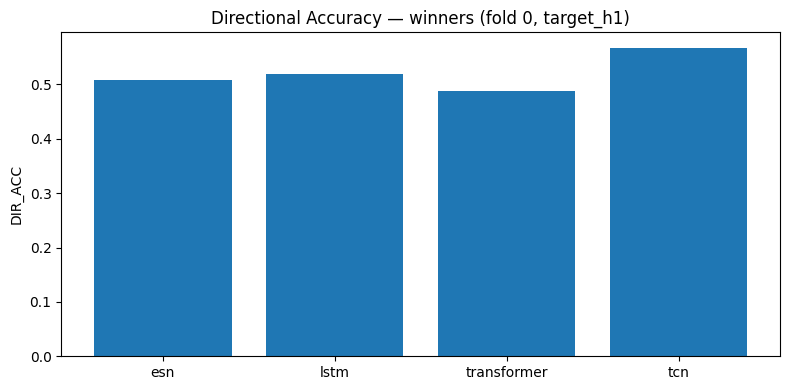

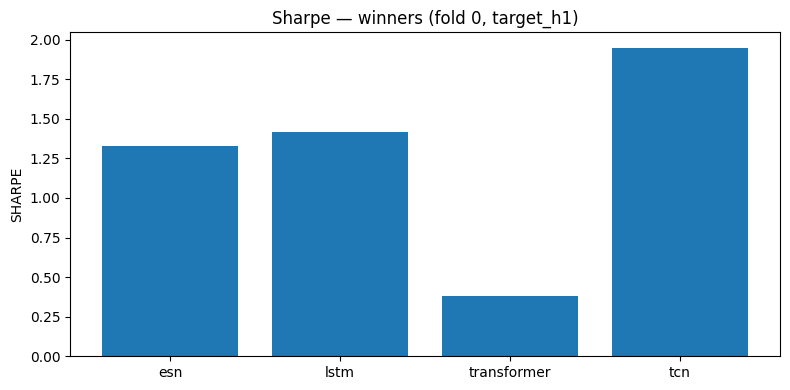

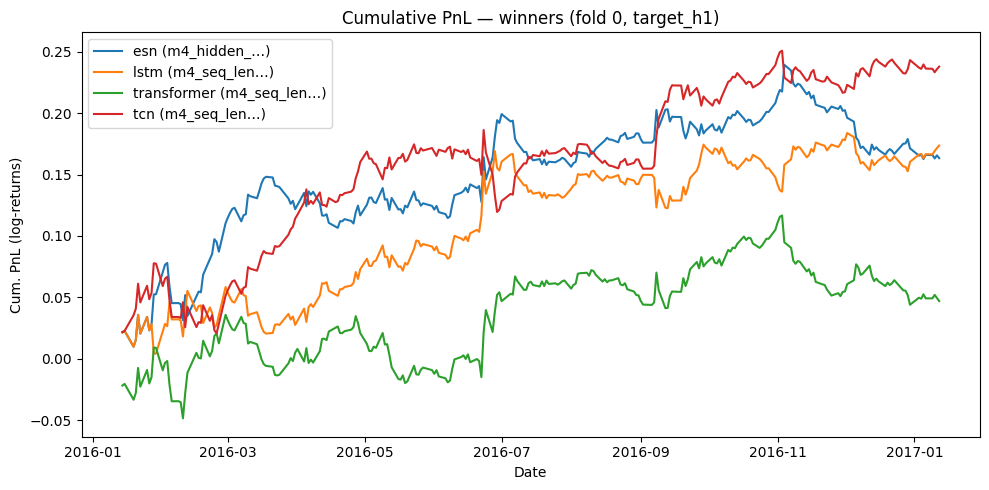

In [17]:
# Take the best-by-Sharpe exp_id for each model
winners = leader_sharpe[["model","exp_id"]].dropna()
print("Winners (Sharpe):")
display(winners)

# Build a compact df with metrics for these winners (single fold view via viz.collect_metrics)
# pick one to visualize curves
fold_id = FOLDS[0]
models_keys = winners["model"].tolist()


from pathlib import Path

def load_metrics_exp(model: str, exp_id: str, fold_id: int, horizon: str):
    path = Path(settings.EXP_DIR) / model / exp_id / f"fold_{fold_id}" / f"metrics_{horizon}.json"
    with open(path, "r") as f:
        return json.load(f)

rows = []
for _, row in winners.iterrows():
    M = load_metrics_exp(row["model"], row["exp_id"], fold_id, H)
    base = {k: v for k, v in M.items() if k != "backtest"}
    base.update(M.get("backtest", {}))
    rows.append(base)
df_win = pd.DataFrame(rows)
display(df_win[["model","rmse","mae","r2","dir_acc","sharpe","avg_daily_pnl","turnover"]])

# Bar charts for the winners
from src.viz.plots import plot_metric_bars
plot_metric_bars(df_win.rename(columns={"model":"model"}), metric="rmse",   title=f"RMSE — winners (fold {fold_id}, {H})")
plot_metric_bars(df_win.rename(columns={"model":"model"}), metric="dir_acc",title=f"Directional Accuracy — winners (fold {fold_id}, {H})")
plot_metric_bars(df_win.rename(columns={"model":"model"}), metric="sharpe", title=f"Sharpe — winners (fold {fold_id}, {H})")

# Cumulative PnL curves (recompute pnl from saved preds)
def plot_cum_pnl_from_exp(winners_df, fold_id: int, horizon: str, cost_per_trade: float = 0.0001):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    for _, r in winners_df.iterrows():
        model, exp_id = r["model"], r["exp_id"]
        p = Path(settings.EXP_DIR) / model / exp_id / f"fold_{fold_id}" / f"preds_{horizon}.csv"
        dfp = pd.read_csv(p, index_col=0, parse_dates=True)
        y_true = dfp["y_true"].values
        y_pred = dfp["y_pred"].values
        pos = np.sign(y_pred)
        pos_change = np.abs(np.diff(pos, prepend=0))
        pnl = pos * y_true - cost_per_trade * pos_change
        plt.plot(dfp.index, pnl.cumsum(), label=f"{model} ({exp_id[:10]}…)")

    plt.title(f"Cumulative PnL — winners (fold {fold_id}, {horizon})")
    plt.xlabel("Date"); plt.ylabel("Cum. PnL (log-returns)")
    plt.legend()
    plt.tight_layout(); plt.show()

plot_cum_pnl_from_exp(winners, fold_id, H, cost_per_trade=0.0001)


Focus: esn m4_hidden_size800_spectral_radius0.85_leak_rate0.3_ridge_alpha0


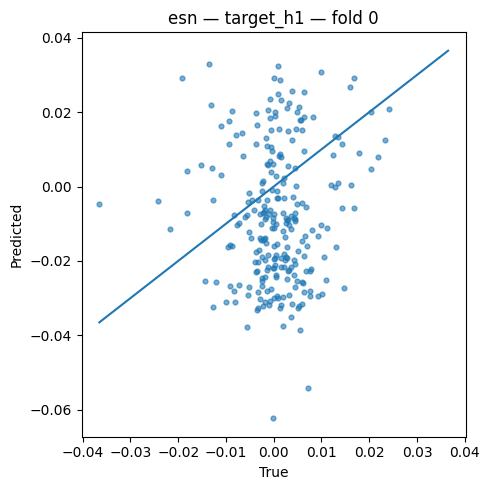

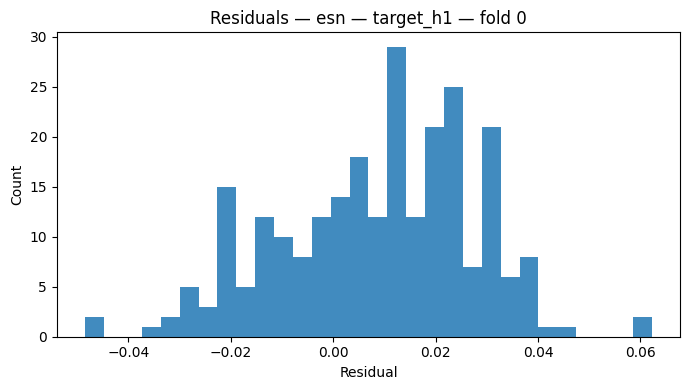

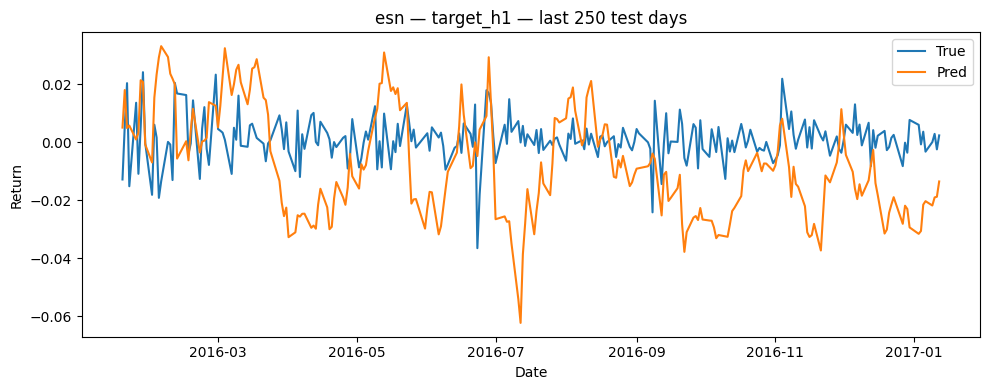

In [18]:
focus_model = winners.iloc[0]["model"]
focus_exp   = winners.iloc[0]["exp_id"]
print("Focus:", focus_model, focus_exp)

# Use the viz helpers by temporarily symlinking to default layout
from pathlib import Path
import matplotlib.pyplot as plt

p = Path(settings.EXP_DIR) / focus_model / focus_exp / f"fold_{fold_id}" / f"preds_{H}.csv"
dfp = pd.read_csv(p, index_col=0, parse_dates=True)
y_true = dfp["y_true"].values
y_pred = dfp["y_pred"].values

# Scatter: y_true vs y_pred
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=12, alpha=0.6)
lim = np.percentile(np.abs(np.concatenate([y_true, y_pred])), 99); lim = max(lim, 1e-3)
xs = np.linspace(-lim, lim, 100); plt.plot(xs, xs)
plt.title(f"{focus_model} — {H} — fold {fold_id}")
plt.xlabel("True"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

# Residual histogram
resid = y_true - y_pred
plt.figure(figsize=(7,4))
plt.hist(resid, bins=30, alpha=0.85)
plt.title(f"Residuals — {focus_model} — {H} — fold {fold_id}")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Last N days time-series
LAST_N = 250
plt.figure(figsize=(10,4))
plt.plot(dfp.index[-LAST_N:], dfp["y_true"].values[-LAST_N:], label="True")
plt.plot(dfp.index[-LAST_N:], dfp["y_pred"].values[-LAST_N:], label="Pred")
plt.title(f"{focus_model} — {H} — last {LAST_N} test days")
plt.xlabel("Date"); plt.ylabel("Return")
plt.legend(); plt.tight_layout(); plt.show()


In [19]:
def summarize_findings(horizon: str, leader_rmse: pd.DataFrame, leader_sharpe: pd.DataFrame) -> str:
    lines = [f"# Milestone 4 Findings — Horizon: {horizon}\n"]
    lines.append("## Best by RMSE (per model)\n")
    if not leader_rmse.empty:
        for _, r in leader_rmse.iterrows():
            lines.append(f"- **{r['model']}**  | RMSE={r['rmse']:.6f}, MAE={r['mae']:.6f}, R²={r['r2']:.3f}, DirAcc={r['dir_acc']:.3f}  | exp_id={r['exp_id']}")
    else:
        lines.append("- (no results)")

    lines.append("\n## Best by Sharpe (per model)\n")
    if not leader_sharpe.empty:
        for _, r in leader_sharpe.iterrows():
            lines.append(f"- **{r['model']}**  | Sharpe={r['sharpe']:.3f}, PnL={r['avg_daily_pnl']:.6f}, Turnover={r['turnover']:.3f}, DirAcc={r['dir_acc']:.3f}  | RMSE={r['rmse']:.6f}  | exp_id={r['exp_id']}")
    else:
        lines.append("- (no results)")

    # A simple bottom line
    if not leader_sharpe.empty:
        best_trader = leader_sharpe.sort_values("sharpe", ascending=False).iloc[0]
        lines.append(f"\n**Bottom line:** For trading (Sharpe), **{best_trader['model']}** looks best. "
                     f"For pure magnitude accuracy (RMSE), refer to the RMSE table above.")
    return "\n".join(lines)

text = summarize_findings(H, leader_rmse, leader_sharpe)
print(text)

# Save to disk
out_txt = os.path.join(settings.EXP_DIR, f"milestone4_findings_{H}.txt")
with open(out_txt, "w") as f:
    f.write(text)
print("\nSaved findings to:", out_txt)


# Milestone 4 Findings — Horizon: target_h1

## Best by RMSE (per model)

- **esn**  | RMSE=0.009101, MAE=0.007012, R²=-0.388, DirAcc=0.500  | exp_id=m4_hidden_size400_spectral_radius0.85_leak_rate0.3_ridge_alpha3
- **lstm**  | RMSE=0.007665, MAE=0.005484, R²=0.015, DirAcc=0.536  | exp_id=m4_seq_len64_hidden256_epochs15_82a1764c
- **transformer**  | RMSE=0.015017, MAE=0.010297, R²=-2.779, DirAcc=0.488  | exp_id=m4_seq_len32_d_model128_epochs15_341648fd
- **tcn**  | RMSE=0.009190, MAE=0.006858, R²=-0.415, DirAcc=0.528  | exp_id=m4_seq_len32_channels64_128_epochs15_3889c8ee

## Best by Sharpe (per model)

- **esn**  | Sharpe=1.330, PnL=0.000648, Turnover=0.210, DirAcc=0.508  | RMSE=0.021002  | exp_id=m4_hidden_size800_spectral_radius0.85_leak_rate0.3_ridge_alpha0
- **lstm**  | Sharpe=1.415, PnL=0.000689, Turnover=0.345, DirAcc=0.520  | RMSE=0.007742  | exp_id=m4_seq_len32_hidden256_epochs15_00960fb7
- **transformer**  | Sharpe=0.381, PnL=0.000187, Turnover=0.520, DirAcc=0.488  | RMSE=0.0

# Milestone 5

In [ ]:
from config import settings
from src.pipeline import run_baseline

# Milestone 5: Evaluate across folds/horizons 

folds_to_run = [0, 1, 2]
horizons = ["target_h1", "target_h5", "target_h20"]

for fold_id in folds_to_run:
    for horizon in horizons:
        result_esn = run_baseline(model_name="esn", fold_id=fold_id, horizon=horizon)
        result_linear_projection = run_baseline(model_name="ridge", fold_id=fold_id, horizon=horizon)
        result_lstm = run_baseline(model_name="lstm", fold_id=fold_id, horizon=horizon)
        result_tf = run_baseline(model_name="transformer", fold_id=fold_id, horizon=horizon)
        result_tcn = run_baseline(model_name="tcn", fold_id=fold_id, horizon=horizon)

        print(result_esn)
        print(result_linear_projection)
        print(result_lstm)
        print(result_tf)
        print(result_tcn)
